# 超参数与模型验证
有监督机器学习模型的基本步骤：
- 选择模型类；
- 选择模型超参数；
- 用模型拟合训练数据；
- 用模型预测新数据的标签。

前两步——**模型选择和超参数选择**——可能是有效使用各种机器学习工具和技术的最重要阶段。为了作出正确的选择，我们需要一种方式来验证选中的模型和超参数是否可以很好地拟合数据。

## 什么是模型验证
模型验证（model validation）其实很简单，就是在选择模型和超参数之后，通过对训练数据进行学习，对比模型对已知数据的预测值与实际值的差异。在下面的几节中，我们首先通过一个简单方法实现模型验证，告诉你为什么那样做行不通。之后，介绍如何用留出集（holdout set）与交叉检验（cross-validation）实现更可靠的模型验证。
### 错误的模型验证方法

In [5]:
from sklearn.datasets import load_iris
iris = load_iris()
X=iris.data
y=iris.target

from sklearn.neighbors import KNeighborsClassifier
model = KNeighborsClassifier(n_neighbors=1)
model.fit(X, y)
y_model=model.predict(X)

from sklearn.metrics import accuracy_score
accuracy_score(y,y_model)

1.0

准确得分是 1.0，也就是说模型识别标签的正确率是 100% 。但是这样测量的准确率可靠吗？答案是否定的。其实这个方法有个根本缺陷：**它用同一套数据训练和评估模型。**另外,最近邻模型是一种与距离相关的评估器，只会简单地存储训练数据，然后把新数据与存储的已知数据进行对比来预测标签。在理想情况下，模型的准确率总是100%。

### 模型验证正确方法： 留出测试集
### 交叉验证
解决这个问题的方法是交叉检验，也就是做一组拟合，让数据的每个子集既是训练集，又是验证集。
![](https://s2.ax1x.com/2020/02/14/1XmVAA.png)

In [ ]:
from sklearn.cross_validation import train_test_split
X1,X2,y1,y2=train_test_split(X,y,random_state=0,train_size=0.5)
y2_model = model.fit(X1, y1).predict(X2)
y1_model = model.fit(X2, y2).predict(X1)

五轮交叉验证：

![](https://s2.ax1x.com/2020/02/14/1Xnqo9.png)

In [7]:
# from sklearn.cross_validation import cross_val_score
from sklearn.model_selection import cross_val_score
cross_val_score(model,X,y,cv=5)

array([0.96666667, 0.96666667, 0.93333333, 0.93333333, 1.        ])

LOO（leave-one-out，只留一个）交叉检验:

In [13]:
from sklearn.model_selection import LeaveOneOut
scores = cross_val_score(model, X, y, cv=LeaveOneOut)
scores

AttributeError: 'numpy.ndarray' object has no attribute '_iter_test_masks'

## 选择最优模型
关键问题是： 假如模型效果不好， 应该如何改善？答案可能有以下几种。
- 用更复杂 / 更灵活的模型。
- 用更简单 / 更确定的模型。
- 采集更多的训练样本。
- 为每个样本采集更多的特征。

### 偏差与方差的均衡
训练得分与验证得分：
![](https://s2.ax1x.com/2020/02/14/1X3Jp9.png)
这个分数是$R^2$，也称为判定系数，用来衡量模型与目标值均值的对比结果。$R^2=1$表示模型与数据完全吻合， $R^2=0$ 表示模型不比简单取均值好，$R^2$为负表示模型性能很差。从这两个模型的得分可以得出两条一般性的结论：
- 对于高偏差模型(欠拟合)，模型在验证集的表现与在训练集的表现类似。
- 对于高方差模型(过拟合)，模型在验证集的表现远远不如在训练集的表现。

下图通常被称为验证曲线，具有以下特征。
- 训练得分肯定高于验证得分。一般情况下，模型拟合自己接触过的数据，比拟合没接触过的数据效果要好。
- 使用复杂度较低的模型（高偏差）时，训练数据往往欠拟合，说明模型对训练数据和新数据都缺乏预测能力。
- 而使用复杂度较高的模型（高方差）时，训练数据往往过拟合，说明模型对训练数据预测能力很强，但是对新数据的预测能力很差。
- 当使用复杂度适中的模型时，验证曲线得分最高。说明在该模型复杂度条件下，偏差与方差达到均衡状态。

![](https://jakevdp.github.io/PythonDataScienceHandbook/figures/05.03-validation-curve.png)

### Scikit-Learn验证曲线
下面来看一个例子，**用交叉检验计算一个模型的验证曲线**。这里用多项式回归模型，它是线性回归模型的一般形式，其多项式的次数是一个可调参数。

In [15]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import make_pipeline# pipeline管道

In [16]:
def PolynomialRegression(degree=2, **kwargs):
    return make_pipeline(PolynomialFeatures(degree),
                        LinearRegression(**kwargs))

In [17]:
import numpy as np
def make_data(N, err=1.0, rseed=1):
    rng = np.random.RandomState(rseed)
    X=rng.rand(N,1)**2
    y=10-1./(X.ravel()+0.1)
    if err>0:
        y+=err*rng.randn(N)
    return X,y
X, y = make_data(40)

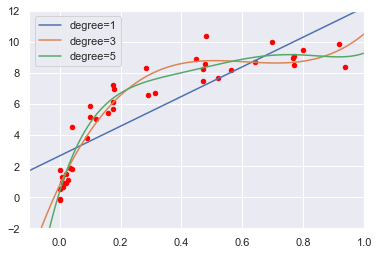

In [23]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn; seaborn.set() # 设置图形样式

X_test = np.linspace(-0.1, 1.1, 500)[:, None]

plt.scatter(X.ravel(), y,s=20, color='red')
axis = plt.axis()
for degree in [1, 3, 5]:
    y_test = PolynomialRegression(degree).fit(X, y).predict(X_test)
    plt.plot(X_test.ravel(), y_test, label='degree={0}'.format(degree))
plt.xlim(-0.1, 1.0)
plt.ylim(-2, 12)
plt.legend(loc='best')

验证曲线的可视化：

Text(0, 0.5, 'score')

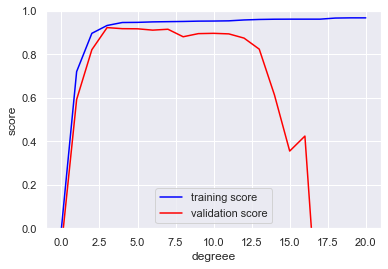

In [25]:
from sklearn.model_selection import validation_curve
degree = np.arange(0, 21)
train_score, val_score = validation_curve(PolynomialRegression(), X, y,
                                          'polynomialfeatures__degree',
                                          degree, cv=7)
plt.plot(degree, np.median(train_score, 1), color='blue', label='training score')
plt.plot(degree, np.median(val_score, 1), color='red', label='validation score')
plt.legend(loc='best')
plt.ylim(0,1)
plt.xlabel('degreee')
plt.ylabel('score')

可见三次多项式的拟合效果最好：

(-0.05673314103942452,
 0.994263633135634,
 -0.7459943120970807,
 10.918045992764213)

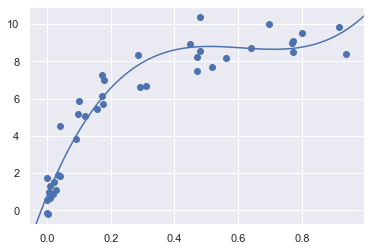

In [28]:
plt.scatter(X.ravel(),y)
lim=plt.axis()
y_test=PolynomialRegression(3).fit(X,y).predict(X_test)
plt.plot(X_test.ravel(),y_test)
plt.axis(lim)

**flatten和ravel：**

两者所要实现的功能是一致的（将多维数组降位一维）。这点从两个单词的意也可以看出来，ravel(散开，解开)，flatten（变平）。两者的区别在于返回拷贝（copy）还是返回视图（view），numpy.flatten()返回一份拷贝，对拷贝所做的修改不会影响（reflects）原始矩阵，而numpy.ravel()返回的是视图（view，也颇有几分C/C++引用reference的意味），会影响（reflects）原始矩阵。

### 学习曲线
影响模型复杂度的另一个重要因素是最优模型往往受到训练数据量的影响。例如，生成前面 5 倍的数据（200 个点）

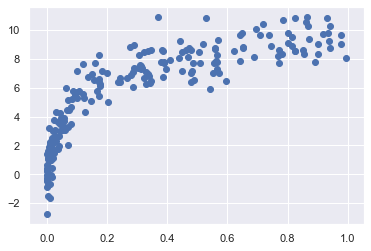

In [32]:
X2,y2=make_data(200)
plt.scatter(X2.ravel(),y2)

Text(0, 0.5, 'score')

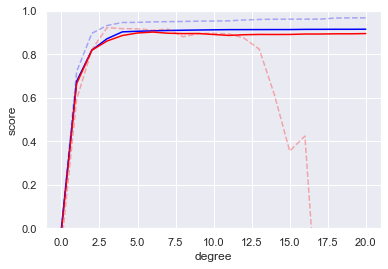

In [33]:
degree=np.arange(21)
train_score2,val_score2=validation_curve(PolynomialRegression(),X2,y2,
                                        'polynomialfeatures__degree',
                                        degree,cv=7)

plt.plot(degree, np.median(train_score2, 1), color='blue',
         label='training score')
plt.plot(degree, np.median(val_score2, 1), color='red', label='validation score')
plt.plot(degree, np.median(train_score, 1), color='blue', alpha=0.3,
         linestyle='dashed')
plt.plot(degree, np.median(val_score, 1), color='red', alpha=0.3,
         linestyle='dashed')

plt.ylim(0, 1)
plt.xlabel('degree')
plt.ylabel('score')

通过观察验证曲线的变化趋势，可以发现有两个影响模型效果的因素：模型复杂度和训练数据集的规模。通常，我们将模型看成是与训练数据规模相关的函数，通过不断扩大数据集的规模来拟合模型，以此来观察模型的行为。反映训练集规模的训练得分/验证得分曲线被称为学习曲线（learning curve）

In [ ]:
from sklearn.model_selection import learning_curve
fig,ax=plt.subplots(1, 2,figsize=(16,6))
fig.subplots_adjust(left=0.0625, right=0.95, wspace=0.1)

for i, degree in enumerate([2, 9]):
    N, train_lc, val_lc = learning_curve(PolynomialRegression(degree),
                                         X, y, cv=7,
                                         train_sizes=np.linspace(0.3, 1, 25))

    ax[i].plot(N, np.mean(train_lc, 1), color='blue', label='training score')
    ax[i].plot(N, np.mean(val_lc, 1), color='red', label='validation score')
    ax[i].hlines(np.mean([train_lc[-1], val_lc[-1]]), N[0], N[-1], color='gray',
                 linestyle='dashed')

    ax[i].set_ylim(0, 1)
    ax[i].set_xlim(N[0], N[-1])
    ax[i].set_xlabel('training size')
    ax[i].set_ylabel('score')
    ax[i].set_title('degree = {0}'.format(degree), size=14)
    ax[i].legend(loc='best')

为模型和数据集画出学习曲线，可以帮你找到正确的方向，不断改进学习的效果。

In [34]:
for i, degree in enumerate([2, 9]):
    print(i,degree)

0 2
1 9


### 验证实践： 网格搜索
在实际工作中，模型通常会有多个得分转折点，因此验证曲线和学习曲线的图形会从二维曲线变成多维曲面。这种高维可视化很难展现，因此从图中找出验证得分的最大值也不是一件简单的事。**Scikit-Learn 在 grid_search 提供了一个自动化工具解决这个问题。**下面是用网格搜索寻找最优多项式回归模型的示例。我们将在模型特征的三维网格中寻找最优值——**包括多项式的次数的搜索范围、回归模型是否拟合截距，以及回归模型是否需要进行标准化处理**。我们可以用 Scikit-Learn 的 `GridSearchCV`元评估器来设置这些参数：

In [41]:
from sklearn.model_selection import GridSearchCV

In [42]:
param_grid={'polynomialfeatures__degree': np.arange(21),
            'linearregression__fit_intercept': [True, False],
            'linearregression__normalize': [True, False]}
# param_grid设置grid的参数
grid = GridSearchCV(PolynomialRegression(), param_grid, cv=7)

#请注意，和普通的评估器一样，这个元评估器此时还没有应用到任何数据上
#调用 fit()方法在每个网格点上拟合模型，并同时记录每个点的得分：

grid.fit(X, y)

GridSearchCV(cv=7, error_score=nan,
             estimator=Pipeline(memory=None,
                                steps=[('polynomialfeatures',
                                        PolynomialFeatures(degree=2,
                                                           include_bias=True,
                                                           interaction_only=False,
                                                           order='C')),
                                       ('linearregression',
                                        LinearRegression(copy_X=True,
                                                         fit_intercept=True,
                                                         n_jobs=None,
                                                         normalize=False))],
                                verbose=False),
             iid='deprecated', n_jobs=None,
             param_grid={'linearregression__fit_intercept': [True, False],
                         'linearre

获取最优参数：

In [45]:
grid.best_params_
# 不需要截距
# 需要正则化
# 最优次数为4

{'linearregression__fit_intercept': False,
 'linearregression__normalize': True,
 'polynomialfeatures__degree': 4}

(-0.05673314103942452,
 0.994263633135634,
 -0.7459943120970807,
 10.918045992764213)

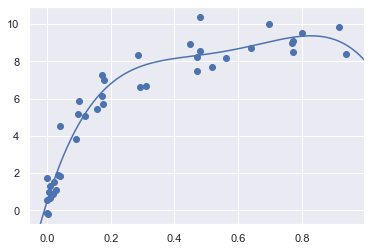

In [48]:
model = grid.best_estimator_

plt.scatter(X.ravel(),y)
lim=plt.axis()
y_test=model.fit(X,y).predict(X_test)
plt.plot(X_test.ravel(),y_test)
plt.axis(lim)